In [58]:
# imports
import os
os.sys.path.append(os.path.abspath("../.."))

import tensorflow as tf

import pandas as pd
import numpy as np
import h5py

from matplotlib import pyplot as plt

from project.notebooks_utils import visuals

from IPython.display import display

import project.download_content as content

from project.utils import data
from project.model.loss import BBOX_REF

from keras.preprocessing import image

from project.model.ssd_model_300_full import ssd_model_300
from project.model.loss import SSDloss

from project.utils.train_test.data_bbox_match_hdf5 import load_model
from project.utils.category_encoder import CategoryEncoder

from project.utils import data_augmentation as da

# one hot encoding
ohc = load_model()

modelpath = os.path.join(os.path.abspath(content.DATAPATH), 'MODEL')

train_files = [f'/media/external/39_classes_300x300_{i}.h5'
               for i in range(8)]

val_files = [os.path.join(modelpath, f'39_classes_300x300_cross_val_{i}.h5')
             for i in range(8)]

test_files = [os.path.join(modelpath, f'39_classes_300x300_test_{i}.h5')
              for i in range(8)]

### Loading one image

In [77]:
# loading a random file of validation dataset
with h5py.File(train_files[3], 'r') as f:
    # selecting a random batch and getting their references
    x_ref, y_ref = f['batches'][3]
    
    # getting Images and Targets from the batch chosen
    X = f[x_ref][:]
    y = f[y_ref][:]
    
display(X.shape)
display(y.shape)

(193, 300, 300, 3)

(193, 8732, 44)

In [61]:
# loading a random file of validation dataset
with h5py.File(val_files[3], 'r') as f:
    # selecting a random batch and getting their references
    x_ref, y_ref, info, bboxes_ref = f['batches'][3]
    
    # getting Images and Targets from the batch chosen
    X = f[x_ref][:]
    y = f[y_ref][:]
    info = f[info][:]
    
display(X.shape)
display(y.shape)
display(info.shape)

bboxes_ref

(300, 300, 300, 3)

(300, 8732, 44)

(300, 2)

'f0bd2837-8b79-4de2-a986-ec0a4bf9708d-bboxes'

In [91]:
sample = 41

# getting a specific image from the batch
img = X[sample]

# getting it target
target = y[sample]

# metadata about the image
# id, raw_path = info[sample]

# with h5py.File(val_files[3], 'r') as f:
#     bboxes = f[bboxes_ref][id][:]

# validate that target has at least one bboxes matched
# (containing 1 and 0 in the first columns (no-class))
display(set(target[:, 0]))

bboxes

{0.0, 1.0}

array([[0.     , 0.     , 0.     , ..., 0.7544 , 0.02031, 0.06665],
       [0.     , 0.     , 0.     , ..., 0.784  , 0.0781 , 0.273  ],
       [0.     , 0.     , 0.     , ..., 0.728  , 0.02344, 0.1188 ],
       ...,
       [0.     , 0.     , 0.     , ..., 0.807  , 0.1656 , 0.3855 ],
       [0.     , 0.     , 0.     , ..., 0.9126 , 0.2    , 0.175  ],
       [0.     , 0.     , 0.     , ..., 0.794  , 0.0734 , 0.06665]],
      dtype=float16)

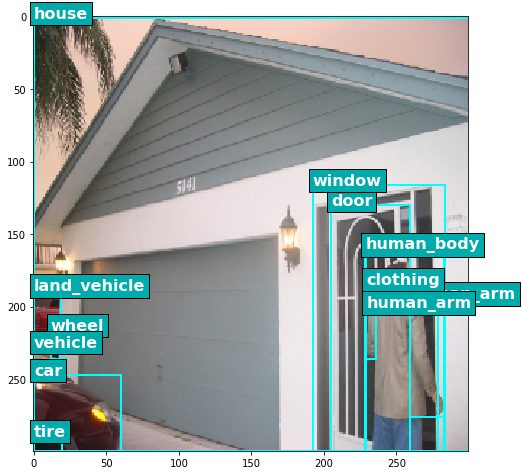

In [66]:
img_jpg = image.load_img('../' + raw_path, target_size=(300, 300))

plt.figure(figsize=(12,8))
plt.imshow(img_jpg)

visuals.draw_many_bboxes(img_jpg, bboxes[:, -4:],
                         label=ohc.inverse_transform(bboxes[:, :-4]));

## model

The model has 7 layers to draw the bounding_boxes, they were called as `number_bbs`

in each layer there are some types of bouding boxes, specified as follow:

|         | number of regions | size of filter in pixels | ratios w/h          | number of bounding boxes |
|---------|-------------------|--------------------------|---------------------|--------------------------|
| 1st_bbs | 5776              | 24px/24px                | [1, 1/2, 2]         | 17328                    |
| 2nd_bbs | 1369              | 48px/48px                | [1, 1/2, 2]         | 4107                     |
| 3rd_bbs | 289               | 98px/98px                | [1, 1/2, 1/3, 2, 3] | 1445                     |
| 4th_bbs | 49                | 208px/208px              | [1, 1/2, 1/3, 2, 3] | 245                      |
| 5th_bbs | 25                | 267px/267px              | [1, 1/2, 1/3, 2, 3] | 125                      |
| 6th_bbs | 9                 | 374px/374px              | [1, 1/2, 1/3, 2, 3] | 45                       |
| 7th_bbs | 1                 | 623px/624px              | [1, 1/2, 1/3, 2, 3] | 5                        |

In [7]:
model = ssd_model_300()

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 300, 300, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 300, 300, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 150, 150, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

## Training

In [84]:
model.load_weights(os.path.abspath(content.DATAPATH) + '/full-weights300vgg16.h5')

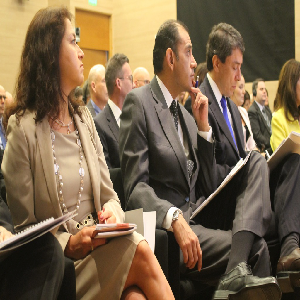

In [85]:
image.array_to_img(img)

In [86]:
norm_img = da.normalize(img)
pred = model.predict(np.expand_dims(norm_img, axis=0))[0]
pred

array([[ 9.1128021e-01,  2.7913786e-03,  1.6476016e-03, ...,
         1.5972199e-01,  3.5216513e+00,  4.8355927e+00],
       [ 8.3961022e-01,  2.4564748e-03,  3.0475801e-03, ...,
         7.7162109e-02,  4.6250949e+00,  3.5438979e+00],
       [ 8.6328626e-01,  2.6180877e-03,  2.4526473e-03, ...,
         1.6215068e-01,  1.8994128e+00,  5.1494694e+00],
       ...,
       [ 6.5744430e-01,  1.4906547e-03,  2.8959415e-03, ...,
         8.2619108e-02,  1.6984644e+00, -3.9310389e+00],
       [ 6.8482852e-01,  1.5516761e-03,  3.3175726e-03, ...,
         1.8726420e-01, -3.9893501e+00,  2.5816422e+00],
       [ 5.1484877e-01,  2.2041963e-03,  4.4704522e-03, ...,
         1.0280528e-01, -1.5547221e+00, -1.2419783e+00]], dtype=float32)

In [74]:
for i, r in enumerate(pred):
    if r[0] < 0.7:
        print(i)

(8732, 44)

In [92]:
target

array([[1.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [1.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [1.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.    , 0.    , ..., 0.6167, 0.9995, 0.7646],
       [0.    , 0.    , 0.    , ..., 0.6167, 0.9995, 0.7646],
       [0.    , 0.    , 0.    , ..., 0.6167, 0.9995, 0.7646]],
      dtype=float16)

In [93]:
pred

array([[ 9.1128021e-01,  2.7913786e-03,  1.6476016e-03, ...,
         1.5972199e-01,  3.5216513e+00,  4.8355927e+00],
       [ 8.3961022e-01,  2.4564748e-03,  3.0475801e-03, ...,
         7.7162109e-02,  4.6250949e+00,  3.5438979e+00],
       [ 8.6328626e-01,  2.6180877e-03,  2.4526473e-03, ...,
         1.6215068e-01,  1.8994128e+00,  5.1494694e+00],
       ...,
       [ 6.5744430e-01,  1.4906547e-03,  2.8959415e-03, ...,
         8.2619108e-02,  1.6984644e+00, -3.9310389e+00],
       [ 6.8482852e-01,  1.5516761e-03,  3.3175726e-03, ...,
         1.8726420e-01, -3.9893501e+00,  2.5816422e+00],
       [ 5.1484877e-01,  2.2041963e-03,  4.4704522e-03, ...,
         1.0280528e-01, -1.5547221e+00, -1.2419783e+00]], dtype=float32)

In [41]:
target = CategoryEncoder.transform(bboxes)
np.argmax(target[:, :-4], axis=1)

array([20,  0, 26, 10])

In [55]:
for i, r in enumerate(target[:, 0]):
    if r == 0:
        print(i)

8728
8729
8730
8731


1

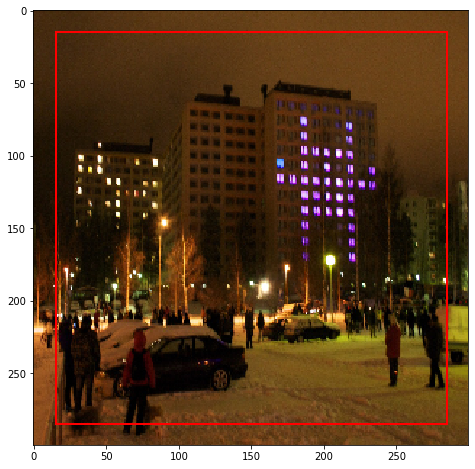

In [14]:
plt.figure(figsize=(12,8))
plt.imshow(img)

tt = 0

bis = []
for i, x in enumerate(pred):
    if i == best_i:
        tt += 1
        b = x
        bi = i
        bis.append(x)
        
        ref = standard_bboxes.references.iloc[bi]
        
        cx = pred[bi][-4]
        cy = pred[bi][-3]
        w = np.exp(pred[bi][-2])
        h = np.exp(pred[bi][-1])
        [cx, cy, w, h]
        
        visuals.draw_bbox(img, ref, color="#ff0000")
tt

1

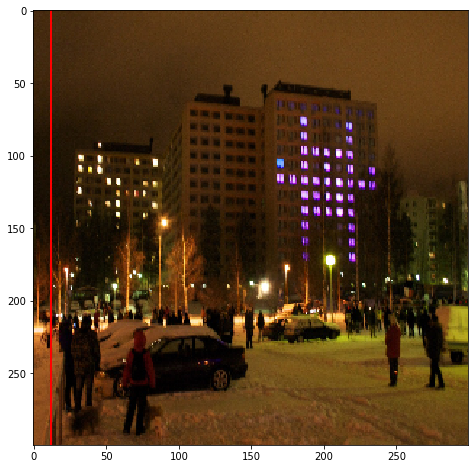

In [18]:
plt.figure(figsize=(12,8))
plt.imshow(img)

tt = 0

bis = []
for i, x in enumerate(pred):
    if i == best_i:
        tt += 1
        b = x
        bi = i
        bis.append(x)
        
        ref = standard_bboxes.references.iloc[bi]
        
        cx = pred[bi][-4]
        cy = pred[bi][-3]
        w = np.exp(pred[bi][-2])
        h = np.exp(pred[bi][-1])
        
        
        visuals.draw_bbox(img, [cx, cy, w, h], color="#ff0000")
tt

In [17]:
h

2.243039